**Table of contents**<a id='toc0_'></a>    
- [Aggregate data by ['Sensor_Name'] or ['Sensor_Name', 'Date']?](#toc1_1_)    
- [The data format used in our research](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Our goal is to cluster the sensors (locations) with similar pattern.

but the original data is in a long format (each row is an observation and each column is a variable).

we need to reformat the data into wide format (individual subjects or items are displayed in rows, and the different observed variables or categories are shown in columns) for further analysis

so should we pivot the data based on location solely or based on location and date?

* Note: this notebook is only for demonstration purpose

In [12]:
import os
import random
import datetime
import zipfile
import gzip
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [13]:
local_path = Path('../../data_preprocessed')
drive_path = Path('/content/drive/MyDrive/ProcessedData_Melbourne_Footfalls')

base_path = local_path if local_path.exists() else drive_path

save_dir = Path('../Results') if local_path.exists() else Path('/content/drive/MyDrive/Results_Melbourne_Footfalls')
if save_dir.exists() == False:
  save_dir.mkdir(parents=True, exist_ok=True)

read_processed_dir = base_path / '1. merged_peds_data_hist_curr'
read_raw_dir = Path('./Data (20230918)') if local_path.exists() else Path('/content/drive/MyDrive/Data/Melbourne_Footfalls')

In [30]:
file_name_to_search = "footfall_merged"

found_files = []

for file in read_processed_dir.iterdir():
  if file.name.startswith(file_name_to_search + "."):
    found_files.append(file)

if len(found_files) == 1:
  file = found_files[0]
  if file.suffix == '.zip': 
    # cannot directly read 'footfall_merged.csv.zip' due to "Multiple files error"
    with zipfile.ZipFile(file, 'r') as z:
      # Extract all files inside the zip file
      z.extractall(read_processed_dir)
      for extracted_file in read_processed_dir.glob(file.stem + '*'):
        if extracted_file.suffix == '.csv':
          data = pd.read_csv(extracted_file)
          break
  elif file.suffix in ['.csv', '.gz']:
    data = pd.read_csv(file)
  # # or using gzip to process file with .gz extension
  # elif file.suffix == '.gz':
  #   with gzip.open(file, 'rt') as f:
  #     data = pd.read_csv(f)
else:
  print(f"{len(found_files)} file(s) found for '{file_name_to_search}'. Please check.")

# data = pd.read_csv(read_processed_dir / 'footfall_merged.csv') # the data should be unpivoted

In [3]:
data.rename(columns={'New_Sensor_Name': 'Sensor_Name'}, inplace=True)
data['Date_Time'] = pd.to_datetime(data['Date_Time'])
start_date = datetime.datetime(2018,1,1)
end_date   = datetime.datetime(2020,1,1)
cut = (data['Date_Time'] >  start_date) & (data['Date_Time'] < end_date) 
data = data.loc[cut]
data = data.dropna(axis='columns', how='any')
data['Hour'] = data['Date_Time'].dt.hour
data['Day'] = data['Date_Time'].dt.dayofweek
data['Date'] = data['Date_Time'].dt.date
data.head()

,Date_Time,Sensor_Name,Hourly_Counts,Location_ID,Installation_Date,Location_Type,Status,Latitude,Longitude,Location,Year,Month,MDate,Day,Hour,Date
1750779,2018-01-01 01:00:00,"Birrarung Marr | FedPed_T, FedCycle_T [7, 122]",1143,7,2014-12-17,Outdoor,A,-37.818629,144.971694,"-37.81862929, 144.97169395",2018,1,1,0,1,2018-01-01
1750780,2018-01-01 01:00:00,Bourke St-Russell St (West) | Rus180_T [21],2035,21,2013-09-02,Outdoor,A,-37.812447,144.967788,"-37.81244703, 144.96778757",2018,1,1,0,1,2018-01-01
1750781,2018-01-01 01:00:00,Bourke Street Mall (North) | Bou292_T [1],890,1,2009-03-24,Outdoor,A,-37.813494,144.965153,"-37.81349441, 144.96515323",2018,1,1,0,1,2018-01-01
1750782,2018-01-01 01:00:00,Bourke Street Mall (South) | Bou283_T [2],590,2,2009-03-30,Outdoor,A,-37.813807,144.965167,"-37.81380668, 144.96516718",2018,1,1,0,1,2018-01-01
1750783,2018-01-01 01:00:00,Chinatown-Lt Bourke St (South) | LtB170_T [20],472,20,2013-09-06,Outdoor,A,-37.811729,144.968247,"-37.81172914, 144.9682466",2018,1,1,0,1,2018-01-01


## <a id='toc1_1_'></a>[Aggregate data by ['Sensor_Name'] or ['Sensor_Name', 'Date']?](#toc0_)

**By Sensor Name**

This approach offers a macro-level perspective, grouping sensors that have similar footfall patterns throughout the week.

**Why choose this?**

If we are interested in understanding the general weekly patterns of each sensor. It gives us a high-level overview and groups sensors with similar weekly behavior.

**What is the object of clustering?**

Sensor_Name / Location

In [4]:
data.pivot_table(index='Sensor_Name', columns='Hour', values='Hourly_Counts', aggfunc='sum').head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Sensor_Name,,,,,,,,,,,,,,,,,,,,,
Alfred Place | AlfPl_T [39],17340,8880,5595,3985,5636,11769,44858,147263,349921,332777,...,262827,201996,234736,310930,193547,110760,71335,65645,53773,33011
"Birrarung Marr | FedPed_T, FedCycle_T [7, 122]",49245,27636,15679,11455,13171,24315,81271,195962,315486,218062,...,347903,324098,442392,575575,650498,439162,277023,230300,358828,203348
Bourke St Bridge | BouBri_T [57],18705,8916,5536,4529,4960,28421,152498,567317,1252242,798372,...,399149,474105,853987,1115913,632899,328535,124109,144162,196120,76527
Bourke St-Russell St (West) | Rus180_T [21],278425,206244,146453,122963,82224,62548,68866,112468,206401,239607,...,785886,752035,773763,914543,927257,865063,763762,646203,537405,401754
Bourke St-Spencer St (North) | Bou688_T [58],70505,39802,27747,15990,13760,41095,129021,397868,759362,575474,...,510723,550477,744575,927121,592294,349523,246361,211655,200806,132546


**By Sensor Name and Date**

This table is more granular, with each sensor's data broken down by individual dates and days.

This approach gives a micro-level perspective, identifying sensors that exhibit similar patterns on particular days. Clustering based on this table will group sensors that have similar patterns on specific dates.

**Why choose this?**

If we are looking for more specific patterns, such as how sensors behave on particular days or looking for anomalies on specific dates

**What is the object of clustering?**

Date (so PCA may not needed)

so extra steps need for cluster assignment.

In [5]:
data.pivot_table(index=['Sensor_Name', 'Date'], columns='Hour', values='Hourly_Counts', aggfunc='sum')

Hour                                      0     1     2     3     4     5   \
Sensor_Name                 Date                                             
Alfred Place | AlfPl_T [39] 2018-02-01  15.0  10.0   4.0   4.0   2.0  13.0   
                            2018-02-02  17.0  25.0   9.0   2.0   5.0  19.0   
                            2018-02-03  38.0  34.0  22.0   7.0   3.0   5.0   
                            2018-02-04  67.0  37.0  28.0  16.0  16.0   4.0   
                            2018-02-05   6.0  19.0   7.0   1.0  21.0  29.0   
...                                      ...   ...   ...   ...   ...   ...   
Webb Bridge | WebBN_T [8]   2019-12-27  10.0   7.0   2.0   6.0   8.0   9.0   
                            2019-12-28  27.0  16.0   8.0   5.0   0.0   9.0   
                            2019-12-29  20.0  10.0  11.0   7.0   2.0   5.0   
                            2019-12-30  24.0   5.0   2.0   1.0   2.0  19.0   
                            2019-12-31  16.0   3.0   5.0   2.0   1.0   6.0   

Hour                                       6      7      8      9   ...  \
Sensor_Name                 Date                                    ...   
Alfred Place | AlfPl_T [39] 2018-02-01  121.0  314.0  707.0  545.0  ...   
                            2018-02-02   59.0  266.0  764.0  693.0  ...   
                            2018-02-03   29.0   60.0  117.0  122.0  ...   
                            2018-02-04    5.0   40.0   70.0  134.0  ...   
                            2018-02-05   65.0  287.0  714.0  619.0  ...   
...                                       ...    ...    ...    ...  ...   
Webb Bridge | WebBN_T [8]   2019-12-27   30.0  135.0  173.0  176.0  ...   
                            2019-12-28   38.0   78.0   96.0  144.0  ...   
                            2019-12-29   33.0   95.0  150.0  151.0  ...   
                            2019-12-30   45.0  114.0  168.0  158.0  ...   
                            2019-12-31   27.0   91.0  122.0  150.0  ...   

Hour                                       14     15     16     17     18  \
Sensor_Name                 Date                                            
Alfred Place | AlfPl_T [39] 2018-02-01  527.0  358.0  446.0  670.0  381.0   
                            2018-02-02  577.0  354.0  391.0  558.0  380.0   
                            2018-02-03  175.0  139.0  188.0  216.0  155.0   
                            2018-02-04  191.0  101.0  107.0   88.0   81.0   
                            2018-02-05  520.0  357.0  417.0  571.0  350.0   
...                                       ...    ...    ...    ...    ...   
Webb Bridge | WebBN_T [8]   2019-12-27  394.0  330.0  321.0  376.0  302.0   
                            2019-12-28  263.0  293.0  270.0  243.0  258.0   
                            2019-12-29  250.0  295.0  272.0  238.0  279.0   
                            2019-12-30  202.0  175.0  157.0  198.0  178.0   
                            2019-12-31  335.0  443.0  352.0  354.0  347.0   

Hour                                       19     20     21     22     23  
Sensor_Name                 Date                                           
Alfred Place | AlfPl_T [39] 2018-02-01  198.0  121.0  114.0   63.0   48.0  
                            2018-02-02  237.0  146.0  151.0  125.0   58.0  
                            2018-02-03  162.0  134.0  140.0  127.0  107.0  
                            2018-02-04   76.0   80.0   51.0   38.0   20.0  
                            2018-02-05  185.0   74.0   83.0   47.0   33.0  
...                                       ...    ...    ...    ...    ...  
Webb Bridge | WebBN_T [8]   2019-12-27  252.0  254.0  169.0  109.0   56.0  
                            2019-12-28  213.0  204.0  135.0   98.0   42.0  
                            2019-12-29  171.0  137.0  157.0  205.0   58.0  
                            2019-12-30   82.0   87.0  100.0   46.0   51.0  
                            2019-12-31  288.0  365.0  456.0  541.0  621.0  

[34112 rows x 24 c

# <a id='toc2_'></a>[The data format used in our research](#toc0_)

In our dataset, we have restructured the data to focus on the temporal activity of each sensor. This restructuring involved grouping the data by the 'Sensor_Name' attribute. As a result, each row in our transformed dataset uniquely represents a specific sensor, identified by its name. The columns, on the other hand, correspond to various timestamps.

suppose we focus on the hourly pedestrain pattern

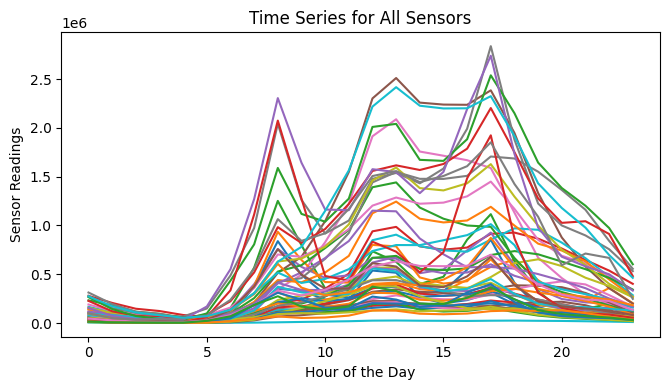

In [11]:
df = data.pivot_table(index='Sensor_Name', columns='Hour', values='Hourly_Counts', aggfunc='sum')
plt.figure(figsize=(8, 4))

for sensor_name, readings in df.iterrows():
    plt.plot(df.columns, readings, label=sensor_name)

plt.xlabel('Hour of the Day')
plt.ylabel('Sensor Readings')
plt.title('Time Series for All Sensors')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

plt.show()

 find the most similar two sensors based on their time series data

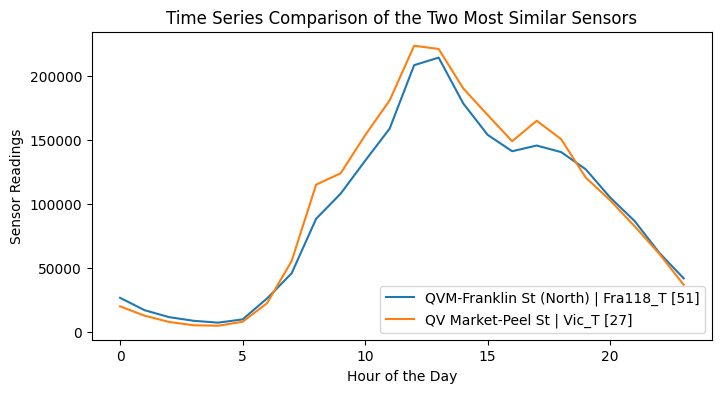

In [17]:
df = data.pivot_table(index='Sensor_Name', columns='Hour', values='Hourly_Counts', aggfunc='sum')
distances = pdist(df, metric='euclidean')
distance_matrix = squareform(distances)

# Replace diagonal and upper triangle with a large number to ignore them
np.fill_diagonal(distance_matrix, np.inf)
distance_matrix[np.triu_indices_from(distance_matrix)] = np.inf

# Find the indices of the minimum distance
min_dist_indices = np.unravel_index(np.argmin(distance_matrix, axis=None), distance_matrix.shape)
sensor1, sensor2 = df.index[min_dist_indices[0]], df.index[min_dist_indices[1]]

# Plotting the time series for the two most similar sensors
plt.figure(figsize=(8, 4))
plt.plot(df.columns, df.loc[sensor1], label=sensor1)
plt.plot(df.columns, df.loc[sensor2], label=sensor2)
plt.xlabel('Hour of the Day')
plt.ylabel('Sensor Readings')
plt.title('Time Series Comparison of the Two Most Similar Sensors')
plt.legend()
plt.show()

find time series that are similar in shape but shifted in time

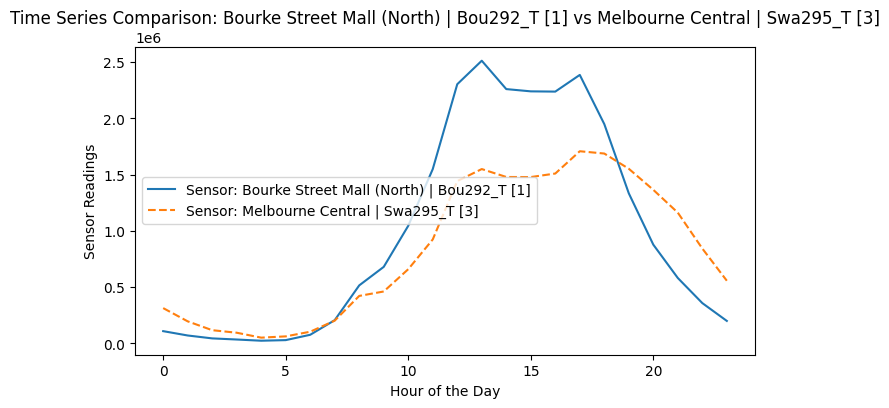

In [20]:
correlation_results = []

# Compute cross-correlation for each pair
for i in range(len(df)):
    for j in range(i+1, len(df)):
        sensor1 = df.iloc[i]
        sensor2 = df.iloc[j]
        cross_corr = np.correlate(sensor1 - sensor1.mean(), sensor2 - sensor2.mean(), mode='full')
        max_corr = np.max(cross_corr)
        shift = np.argmax(cross_corr) - (len(sensor1) - 1)

        # Ignore pairs with zero shift
        if shift != 0:
            correlation_results.append({
                'Sensor1': df.index[i],
                'Sensor2': df.index[j],
                'MaxCorrelation': max_corr,
                'Shift': shift
            })

correlation_results_df = pd.DataFrame(correlation_results)

most_similar_pair = correlation_results_df.loc[correlation_results_df['MaxCorrelation'].idxmax()]

sensor1_name = most_similar_pair['Sensor1']
sensor2_name = most_similar_pair['Sensor2']

sensor1_data = df.loc[sensor1_name]
sensor2_data = df.loc[sensor2_name]

plt.figure(figsize=(8, 4))
plt.plot(df.columns, sensor1_data, label=f'Sensor: {sensor1_name}')
plt.plot(df.columns, sensor2_data, label=f'Sensor: {sensor2_name}', linestyle='--')

plt.xlabel('Hour of the Day')
plt.ylabel('Sensor Readings')
plt.title(f'Time Series Comparison: {sensor1_name} vs {sensor2_name}')
plt.legend()
plt.show()

find two time series that fit your criteria (one peaking at an early hour and another at a late hour, with flat off-peak hours)

In [26]:
def is_flat(series, start, end, flatness_threshold):
    outside_range = series.drop(series.index[start:end+1])
    return outside_range.std() < flatness_threshold

peak_threshold = 0.5 
flatness_threshold = 0.4  

potential_pairs = []

for i in range(len(df)):
    for j in range(i+1, len(df)):
        sensor1 = df.iloc[i]
        sensor2 = df.iloc[j]

        # Check for peak in sensor1 and sensor2
        if sensor1.max() > sensor1.quantile(peak_threshold) and \
           sensor2.max() > sensor2.quantile(peak_threshold):

            # Determine peak hours
            early_peak_hours_sensor1 = sensor1.idxmax() < 12  # Peak before 12 PM
            late_peak_hours_sensor2 = sensor2.idxmax() >= 12  # Peak after 12 PM

            # Check if the series is flat outside peak hours
            if early_peak_hours_sensor1 and late_peak_hours_sensor2 and \
               is_flat(sensor1, 0, 11, flatness_threshold) and \
               is_flat(sensor2, 12, 23, flatness_threshold):
                potential_pairs.append((df.index[i], df.index[j]))

# Display potential pairs
print("Potential Pairs of Sensors with the Specified Peak and Flatness Characteristics:")
for pair in potential_pairs:
    print(pair)


Potential Pairs of Sensors with the Specified Peak and Flatness Characteristics:
